# Meta Learner algorithm

> A meta-algorithm (or meta-learner) is a framework to estimate the Conditional Average Treatment Effect (CATE) using any machine learning estimators (called base learners)

In [56]:
from causalml.inference.meta import BaseRRegressor
from causalml.inference.meta import BaseSRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('./data/CausalML_test_data.csv')
data.head()

,user_id,treatment,purchase_amount,age,gender,past_purchases
0,1,0,8609,64,M,5
1,2,1,5241,29,F,0
2,3,1,6458,33,M,4
3,4,1,6887,41,M,2
4,5,0,5747,36,F,0


In [4]:
data.describe()

,user_id,treatment,purchase_amount,age,past_purchases
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.497000,6612.149000,40.984000,4.420000
std,288.819436,0.500241,1442.504573,13.582939,2.836485
min,1.000000,0.000000,3767.000000,18.000000,0.000000
25%,250.750000,0.000000,5452.500000,29.000000,2.000000
50%,500.500000,0.000000,6581.500000,41.000000,4.000000
75%,750.250000,1.000000,7786.000000,53.000000,7.000000
max,1000.000000,1.000000,9916.000000,64.000000,9.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          1000 non-null   int64 
 1   treatment        1000 non-null   int64 
 2   purchase_amount  1000 non-null   int64 
 3   age              1000 non-null   int64 
 4   gender           1000 non-null   object
 5   past_purchases   1000 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


In [7]:
le = LabelEncoder()
data['gender'] = le.fit_transform(data['gender'])
data.head()

,user_id,treatment,purchase_amount,age,gender,past_purchases
0,1,0,8609,64,1,5
1,2,1,5241,29,0,0
2,3,1,6458,33,1,4
3,4,1,6887,41,1,2
4,5,0,5747,36,0,0


## Average Treatment Effect (ATE) estimation

using the S-learner in the causalML package

In [14]:
estimator = BaseSRegressor(learner=GradientBoostingRegressor()
                           )

ate_estimate = estimator.estimate_ate(
    X=data[['age','gender','past_purchases']],
    treatment=data['treatment'],
    y=data['purchase_amount']
)

print(f'Average Treatment Effect (ATE): {ate_estimate[0]:.2f}')

Average Treatment Effect (ATE): 571.50


## Conditional Treatment Effect (CTE) estimation
using R-learner in the causalML package

In [17]:
cate_estimator = BaseRRegressor(learner=RandomForestRegressor())

cate_estimates = cate_estimator.fit_predict(
    X=data[['age', 'gender', 'past_purchases']],
    treatment=data['treatment'],
    y=data['purchase_amount']
)

cate_estimates_df = pd.DataFrame(
    cate_estimates,
    columns=['CATE'],
    index=data.index)

cate_data = pd.concat(
    [data, cate_estimates_df],
    axis=1)
print('Conditional Average Treatment Effects (CATE):')
display(cate_data)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Conditional Average Treatment Effects (CATE):


,user_id,treatment,purchase_amount,age,gender,past_purchases,CATE
0,1,0,8609,64,1,5,1577.219248
1,2,1,5241,29,0,0,142.796352
2,3,1,6458,33,1,4,356.728508
3,4,1,6887,41,1,2,961.574375
4,5,0,5747,36,0,0,533.800599
...,...,...,...,...,...,...,...
995,996,0,6590,40,1,7,627.047469
996,997,1,7379,43,1,6,573.089389
997,998,0,4341,21,1,5,450.417614
998,999,1,5810,35,0,0,364.743725


### Visualize CATE by Age and Gender

In [42]:
cate_data['age_group'] = (cate_data['age'] //10) * 10
cate_by_age_gender_group = cate_data.groupby(['age_group','gender'])['CATE'].mean().reset_index()
cate_by_age_gender_group

,age_group,gender,CATE
0,10,0,494.880653
1,10,1,637.710499
2,20,0,396.551598
3,20,1,704.246390
4,30,0,334.347460
5,30,1,798.317662
6,40,0,245.582120
7,40,1,992.704135
8,50,0,279.289625
9,50,1,1094.190512


Text(0, 0.5, 'CATE')

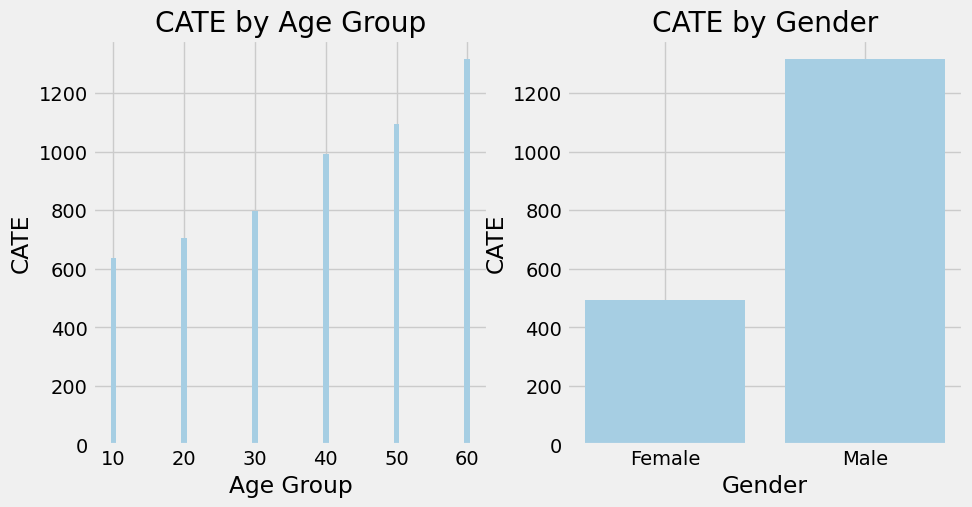

In [29]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(cate_by_age_gender_group.age_group, cate_by_age_gender_group['CATE'])
ax[0].set_title('CATE by Age Group')
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('CATE')
ax[1].bar(cate_by_age_gender_group.gender, cate_by_age_gender_group['CATE'])
ax[1].set_title('CATE by Gender')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('CATE')

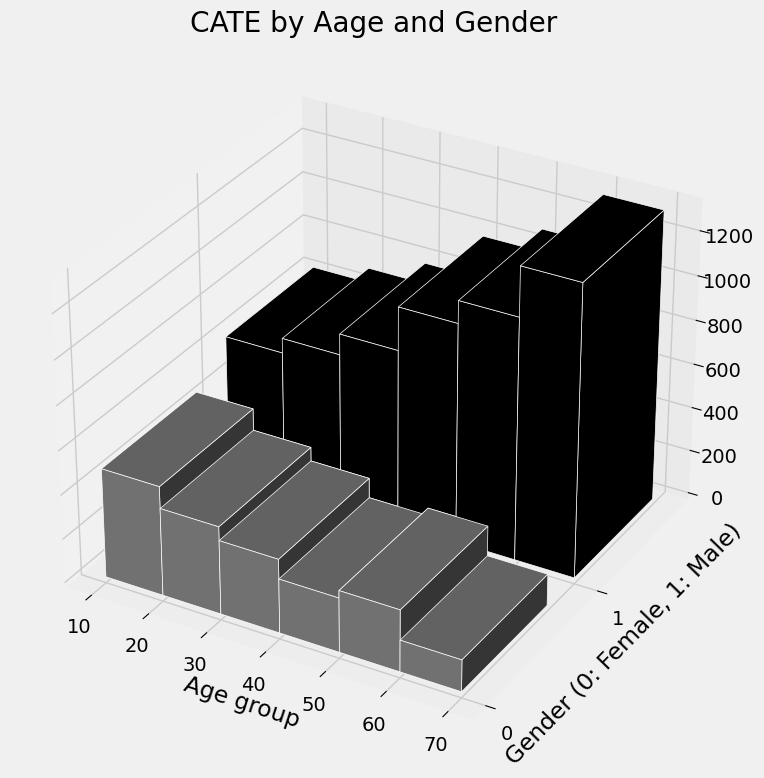

In [53]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

xpos= cate_by_age_gender_group['age_group']
ypos=cate_by_age_gender_group['gender']
zpos=np.zeros_like(xpos)

dx = 10
dy =0.75
dz = cate_by_age_gender_group['CATE'].values

gender_ticks = np.unique(cate_by_age_gender_group['gender'])
gender_colors = ['black' if x==1 else 'grey' for x in cate_by_age_gender_group['gender']]

ax.bar3d(xpos,
         ypos,
         zpos,
         dx,
         dy,
         dz,
         color=gender_colors,
         zsort='average',
         shade=True,
         edgecolor='white')

ax.set_xlabel('Age group')
ax.set_ylabel('Gender (0: Female, 1: Male)')
ax.set_title('CATE by Aage and Gender')
ax.set_yticks(gender_ticks)

plt.tight_layout()
plt.show()

## Treatment Response Fucntion Estimation

Estimate individual customer CATE

In [71]:
X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(
    data[['age','gender','past_purchases']],
    data['treatment'],
    data['purchase_amount'],
    test_size=0.20,
    random_state=51
)

In [72]:
dr_estimator = BaseRRegressor(learner=RandomForestRegressor())

dr_estimator.fit(
    X= X_train,
    treatment=treatment_train,
    y=y_train
)

preds = dr_estimator.predict(X_test)
df_preds = pd.DataFrame(
    preds,
    columns=['CATE'],
    index=X_test.index
)

pred_X_test = pd.concat(
    [X_test, df_preds],
    axis=1)

print('Treatment Response Function Predictions (CATE):')
display(pred_X_test)

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.11/site-packages/

Treatment Response Function Predictions (CATE):


,age,gender,past_purchases,CATE
833,32,0,8,388.391169
551,31,1,1,110.743377
782,39,0,8,101.441496
535,20,1,5,1186.413314
144,23,1,6,1402.553530
...,...,...,...,...
975,49,0,0,33.692418
971,39,0,9,683.016898
366,44,0,2,-230.460246
479,35,0,3,503.246457
